In [59]:
# pip install beautifulsoup4    # Download and install beautiful soup 4
# pip install lxml              # Download and install lxml for its XML and HTML parser
# pip install requests          # Download and install Python requests module
# pip install seaborn           # Download and install Seaborn for visualizations

from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import csv

import requests
import sys
import re

import sklearn
import sklearn.cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

fund_house_count=6   # number of top fund houses to be analyzed
f_scheme_count=50    # Maximum number of fund schemes to be analyzed

money_control_root = 'http://www.moneycontrol.com'

#to ignore A value is trying to be set on a copy of a slice from a DataFrame Warning
pd.options.mode.chained_assignment = None  # default='warn'

#to ignore DeprecationWarning
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [60]:
# Get 10 mutual fund families with the highest Assets under Management from Money Control
markup = requests.get(money_control_root + '/mutual-funds/amc-assets-monitor').text

# make the soup
soup = BeautifulSoup(markup, "lxml")

# the table that contains the required data
table = soup.find_all('table', attrs = {"class": "tblfund1"})[0]

# get the first ten rows in this table, excluding
# the first row as it has only header information
rows = table.find_all('tr')[1:fund_house_count]


# Fund Family and Assets under Management (Rs. Cr.) for the top 10 mutual fund families
fund_fam = []
for r in rows:
    ff_dict = {
        'fund_fam_name': unicode( r.contents[1].a.string ),
        'fund_fam_url' : unicode( money_control_root + r.contents[1].a.attrs['href'] ),
        'fund_fam_aum' : unicode( r.contents[5].string ),
        'fund_fam_sc' : unicode( money_control_root + r.contents[1].a.attrs['href'] ).split('/')[-1]
    }
    
    fund_fam.append( ff_dict )

In [3]:
print( fund_fam )

[{'fund_fam_aum': u'342,291', 'fund_fam_name': u'HDFC Mutual Fund', 'fund_fam_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/HD', 'fund_fam_sc': u'HD'}, {'fund_fam_aum': u'320,793', 'fund_fam_name': u'ICICI Prudential Mutual Fund', 'fund_fam_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/PI', 'fund_fam_sc': u'PI'}, {'fund_fam_aum': u'283,807', 'fund_fam_name': u'SBI Mutual Fund', 'fund_fam_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/SB', 'fund_fam_sc': u'SB'}, {'fund_fam_aum': u'246,480', 'fund_fam_name': u'Aditya Birla Sun Life Mutual Fund', 'fund_fam_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/BS', 'fund_fam_sc': u'BS'}, {'fund_fam_aum': u'233,617', 'fund_fam_name': u'Reliance Mutual Fund', 'fund_fam_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/RC', 'fund_fam_sc': u'RC'}]


In [4]:
# For each fund family, get a list of all fund schemes along with other details
f_schemes = []
for fund in fund_fam:
    
    markup = requests.get( fund['fund_fam_url'] ).text

    soup = BeautifulSoup(markup, "lxml")

    rows = soup.select('.FL.MT10.boxBg table tr')[1:-1]
    
    for r in rows:
        data_elems      = r.find_all('td')
    
        cat_name   = ''
        sch_aum      = ''
        cat_url    = ''
        
        try:
            cat_name   = unicode( data_elems[2].a.string )
            cat_url    = money_control_root + data_elems[2].a.attrs['href']
            
        except AttributeError:
            cat_name   = u'None'
            cat_url    = u'None'
    
        try:
            sch_aum = unicode( data_elems[5].string )
        except AttributeError:
            sch_aum = u'None'

        f_scheme_dict    = {
            'fund_fam_name'      : fund['fund_fam_name'],
            'fund_fam_url'       : fund['fund_fam_url' ],
            'fund_fam_aum'       : fund['fund_fam_aum' ],
            'fund_fam_sc' : fund['fund_fam_sc'],
            'sch_name'           : unicode( data_elems[0].a.string ),
            'sch_url'            : money_control_root + data_elems[0].a.attrs['href'],
            'crisil_rating'         : unicode( data_elems[1].a.string ),
            'category'              : cat_name,
            'cat_url'          : cat_url,
            'latest_nav'            : unicode( data_elems[3].string ),
            '1yr_return'            : u'None' if unicode( data_elems[4].string ) == u'--' else unicode( data_elems[4].string ),
            'sch_aum'            : sch_aum
        }

        f_schemes.append( f_scheme_dict )

In [5]:
print( len( f_schemes ), '\n\n', f_schemes[:1])

(982, '\n\n', [{'fund_fam_aum': u'342,291', 'fund_fam_sc': u'HD', 'sch_url': 'http://www.moneycontrol.com/mutual-funds/nav/hdfc-arbitrage-fund-direct-plan/MHD1171', 'latest_nav': u'22.39', 'fund_fam_name': u'HDFC Mutual Fund', 'fund_fam_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/HD', 'category': u'Arbitrage Fund', 'sch_name': u'HDFC Arbitrage Fund - Direct (G)', 'sch_aum': u'2.63', '1yr_return': u'6.5', 'cat_url': 'http://www.moneycontrol.com/mutual-funds/performance-tracker/returns/arbitrage-fund.html', 'crisil_rating': u'Rank 3'}])


In [6]:
f_schemes = f_schemes[:f_scheme_count]


In [7]:
for idx, scheme in enumerate(f_schemes):
    try:        
        # Read the page at the URL for each scheme
        markup = requests.get(scheme['sch_url']).text
        soup = BeautifulSoup(markup, "lxml")

        # Riskometer (Risk Rating)
        scheme['sch_text_risk'] = unicode(soup.select_one(".status").text)

        # Fund Category
        scheme['sch_fund_type'] = unicode(soup.select_one(".sub_category_text").text)
        
        # Scheme Plan and Scheme Option
        sch_plan_option_data    = [unicode( x.string ).strip() for x in soup.select('#planname_frm .FL span')]

        [scheme['sch_plan'],
        scheme['sch_option'] ] = sch_plan_option_data if sch_plan_option_data else [u'None', u'None']

        
        #insert_position=scheme["sch_url"].rfind('/')
        #scheme['return_url'] = unicode(scheme["sch_url"][:insert_position] + '/returns' + scheme["sch_url"][insert_position:])
        #print(scheme['sch_url'], scheme['return_url'])

        # markup2 = requests.get(scheme['return_url']).text
        # soup2 = BeautifulSoup(markup2, "lxml")
        
        returns_table = soup.find('table',{'class':'mctable1'})
        rows = returns_table.findAll('tr')

        for row in rows:
            row_attrs = [x for x in row.children if unicode(x).strip()]

            row_name  = unicode(row_attrs[0].string).strip().lower()

            # fund returns
            if row_name == '1 week':
                    scheme['f_return_1wk']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_ret_avg_1wk']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
                    scheme['rank_in_cat_1wk']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )

            if row_name == '1 month':
                    scheme['f_return_1m']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_ret_avg_1m']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
                    scheme['rank_in_cat_1m']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )

            if row_name == '3 month':
                    scheme['f_return_3m']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_ret_avg_3m']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
                    scheme['rank_in_cat_3m']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )

            if row_name == '6 month':
                    scheme['f_return_6m']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_ret_avg_6m']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
                    scheme['rank_in_cat_6m']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )

            if row_name == '1 year':
                    scheme['f_return_1yr']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_ret_avg_1yr']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
                    scheme['rank_in_cat_1yr']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )

            if row_name == '2 year':
                    scheme['f_return_2yr']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_ret_avg_2yr']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
                    scheme['rank_in_cat_2yr']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )

            if row_name == '3 year':
                    scheme['f_return_3yr']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_ret_avg_3yr']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
                    scheme['rank_in_cat_3yr']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )

            if row_name == '5 year':
                    scheme['f_return_5y']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_ret_avg_5y']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
                    scheme['rank_in_cat_5y']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )

            if row_name == '10 year':
                    scheme['f_return_10y']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
                    scheme['cat_ret_avg_10y']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )

            if row_name == 'since inception':
                    scheme['f_return_si']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )

        # Print every 100th scheme to verify things are running smoothly
        if idx % 200 == 0:
            print( 'Scheme # {0}\n{1}\n\n\n'.format(idx, scheme) )
        else:
            print idx, ' ',

    except:
        pass


Scheme # 0
{'fund_fam_aum': u'342,291', 'rank_in_cat_6m': u'15/21', 'fund_fam_sc': u'HD', 'sch_plan': u'None', 'sch_text_risk': u'Moderately Low', 'fund_fam_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/HD', 'rank_in_cat_2yr': u'15/18', 'cat_ret_avg_3yr': u'6.52%', 'cat_ret_avg_3m': u'1.71%', 'rank_in_cat_1yr': u'13/19', 'cat_ret_avg_1wk': u'0.04%', 'rank_in_cat_1m': u'9/24', 'latest_nav': u'22.39', 'rank_in_cat_5y': u'9/11', 'f_return_3yr': u'20.51%', 'cat_ret_avg_1yr': u'6.37%', 'rank_in_cat_1wk': u'15/24', '1yr_return': u'6.5', 'cat_url': 'http://www.moneycontrol.com/mutual-funds/performance-tracker/returns/arbitrage-fund.html', 'f_return_3m': u'1.73%', 'cat_ret_avg_2yr': u'6.36%', 'f_return_6m': u'3.10%', 'f_return_10y': u'-', 'sch_fund_type': u'Arbitrage Fund', 'f_return_1wk': u'0.03%', 'sch_url': 'http://www.moneycontrol.com/mutual-funds/nav/hdfc-arbitrage-fund-direct-plan/MHD1171', 'fund_fam_name': u'HDFC Mutual Fund', 'sch_aum': u'2.63', 'cat_ret_avg_5y': u'7.15%

In [8]:

#Save the collected data to text, which is then converted to a csv file.

out_path= "./top_schemes.csv"
out_file = open(out_path, 'wb')

fieldnames = sorted(list(set(k for d in f_schemes for k in d)))
writer = csv.DictWriter(out_file, fieldnames=fieldnames, dialect='excel')

writer.writeheader() 
for row in f_schemes:
    writer.writerow(row)
out_file.close()


In [9]:
# Data Engineering to prepare the data for ML

def encode_risk(text_risk):
    '''
    Method to convert risk text to a numerical attribute
    '''
    # The higher the risk, the lower the score!
    risk = {
        u'HIGH'              :  1,
        u'MODERATELY HIGH'   :  2,
        u'MODERATE'          :  3,
        u'MODERATELY LOW'    :  4,
        u'LOW'               :  5 
    }
    try:
        return risk[ unicode( text_risk.upper() ) ]
    except:
        return 0

'''
Method to convert numerical features that appear as strings or unicode strings into numbers
'''
def conv_numeric( text ):
    try:
        return float( re.sub(
            '(Rs[ ]*\.)|[^\d|.|-]|(Rank[ ]*)',
            '',
            text,
            flags = re.IGNORECASE
        ) )
    except:
        return None

In [20]:
sum1=0

# Initialize a list to store metrics for risk
for idx, scheme in enumerate( f_schemes ):
    ##
    # Step 1: Convert numerical features appearing as text to numerical features
    #         1.a: Encode risk text to a numerical representation of risk.
    #              Highest risk gets the lowest score, lowest risk gets the highest score
    #
    #         1.b: Convert numbers formatted with commas or currency or rating description to just numbers
    ##
    
    # Convert scheme risk text to a numerical attribute
    try:
        f_schemes[idx]['num_scheme_risk']      = encode_risk( scheme['sch_text_risk'] )/5
    except:
        f_schemes[idx]['num_scheme_risk'] = 0
    
    # Convert metrics to numerical features
    try:
        f_schemes[idx]['num_crisil_rating']    = conv_numeric( scheme['crisil_rating'] )
    except:
        f_schemes[idx]['num_crisil_rating'] = 0
        

    try:
        f_schemes[idx]['num_fund_fam_aum']  = conv_numeric( scheme['fund_fam_aum'] )
    except:
        f_schemes[idx]['num_fund_fam_aum'] = 0
    
    try:
        f_schemes[idx]['num_sch_aum']       = conv_numeric( scheme['sch_aum'] ) if scheme['sch_aum'] != u'None' else 0
    except:
        f_schemes[idx]['num_sch_aum'] = 0
    
    try:
        f_schemes[idx]['num_f_return_1wk']     = conv_numeric( scheme['f_return_1wk'] )
    except:
        f_schemes[idx]['num_f_return_1wk'] = 0
        
    try:
        f_schemes[idx]['num_f_return_1m']      = conv_numeric( scheme['f_return_1m'] )
    except:
        f_schemes[idx]['num_f_return_1m'] = 0

    try:
        f_schemes[idx]['num_f_return_3m']      = conv_numeric( scheme['f_return_3m'] )
    except:
        f_schemes[idx]['num_f_return_3m'] = 0
    
    try:
        f_schemes[idx]['num_f_return_6m']      = conv_numeric( scheme['f_return_6m'] )
    except:
        f_schemes[idx]['num_f_return_6m'] = 0
    
    try:
        f_schemes[idx]['num_f_return_1yr']      = conv_numeric( scheme['f_return_1yr'] )
    except:
        f_schemes[idx]['num_f_return_1yr'] = 0
    
    try:
        f_schemes[idx]['num_f_return_2yr']      = conv_numeric( scheme['f_return_2yr'] )
    except:
        f_schemes[idx]['num_f_return_2yr'] = 0
    
    try:
        f_schemes[idx]['num_f_return_3yr']      = conv_numeric( scheme['f_return_3yr'] )
    except:
        f_schemes[idx]['num_f_return_3yr'] = 0
    
    try:
        f_schemes[idx]['num_f_return_5y']      = conv_numeric( scheme['f_return_5y'] )
    except:
        f_schemes[idx]['num_f_return_5y'] = 0
    
    try:
        f_schemes[idx]['num_f_return_si']      = conv_numeric( scheme['f_return_si'] )
    except:
        f_schemes[idx]['num_f_return_si'] = 0
    
    try:
        f_schemes[idx]['num_latest_nav']       = conv_numeric( scheme['latest_nav'] )
    except:
        f_schemes[idx]['num_latest_nav'] = 0
    
    
    
    try:
        f_schemes[idx]['num_cat_ret_avg_1wk']  = conv_numeric( scheme['cat_ret_avg_1wk'] )
    except:
        f_schemes[idx]['num_cat_ret_avg_1wk'] = 0
    
    try:
        f_schemes[idx]['num_cat_ret_avg_1m']   = conv_numeric( scheme['cat_ret_avg_1m'] )
    except:
        f_schemes[idx]['num_cat_ret_avg_1m'] = 0
    
    try:
        f_schemes[idx]['num_cat_ret_avg_3m']   = conv_numeric( scheme['cat_ret_avg_3m'] )
    except:
        f_schemes[idx]['num_cat_ret_avg_3m'] = 0
    
    try:
        f_schemes[idx]['num_cat_ret_avg_6m']   = conv_numeric( scheme['cat_ret_avg_6m'] )
    except:
        f_schemes[idx]['num_cat_ret_avg_6m'] = 0
    
    try:
        f_schemes[idx]['num_cat_ret_avg_1yr']   = conv_numeric( scheme['cat_ret_avg_1yr'] )
    except:
        f_schemes[idx]['num_cat_ret_avg_1yr'] = 0
    
    try:
        f_schemes[idx]['num_cat_ret_avg_2yr']   = conv_numeric( scheme['cat_ret_avg_2yr'] )
    except:
        f_schemes[idx]['num_cat_ret_avg_2yr'] = 0
    
    try:
        f_schemes[idx]['num_cat_ret_avg_3yr']   = conv_numeric( scheme['cat_ret_avg_3yr'] )
    except:
        f_schemes[idx]['num_cat_ret_avg_3yr'] = 0
    
    try:
        f_schemes[idx]['num_cat_ret_avg_5y']   = conv_numeric( scheme['cat_ret_avg_5y'] )
    except:
        f_schemes[idx]['num_cat_ret_avg_5y'] = 0
    
    
    ##
    # Step 2: Calculate additional risk metrics - the fetched risk rating is based on MPT Statistics
    #         which is already a sound measurement. Hence, we devise and incorporate more measures
    #         such as:
    ##
    
    # Score between 0 and 1 based on Risk Rating which is based on MPT Statistics
    f_schemes[idx]['cstm_risk_rating'] = f_schemes[idx]['num_scheme_risk'] / 5.0
    
    # Score between 0 and 1 based on CRISIL rating
    if scheme['num_crisil_rating'] == None:
        scheme['num_crisil_rating'] = 0.0

    f_schemes[idx]['cstm_crisil']  = f_schemes[idx]['num_crisil_rating'] / 5.0 if f_schemes[idx]['num_crisil_rating'] else 0
    
    # Score between 0 and 1 based on AUM allocation to the scheme compared to other schemes in the fund family
    f_schemes[idx]['cstm_alloc'] = float( f_schemes[idx]['num_sch_aum'] ) / ( f_schemes[idx]['num_fund_fam_aum'] - f_schemes[idx]['num_sch_aum'] )
    
    # Convert Rank within Categoty to numeric field between 0 to 1, 0 lowest rank, 1 higher rank
    try: 
        f_schemes[idx]['cstm_diff_1wk'] = 1 - float(scheme['rank_in_cat_1wk'][:pos]) / float(scheme['rank_in_cat_1wk'][pos+1:])
    except:
        f_schemes[idx]['cstm_diff_1wk'] = 0

    try: 
        f_schemes[idx]['cstm_diff_1m'] = 1 - float(scheme['rank_in_cat_1m'][:pos]) / float(scheme['rank_in_cat_1m'][pos+1:])
    except:
        f_schemes[idx]['cstm_diff_1m'] = 0

    try: 
        f_schemes[idx]['cstm_diff_3m'] = 1 - float(scheme['rank_in_cat_3m'][:pos]) / float(scheme['rank_in_cat_3m'][pos+1:])
    except:
        f_schemes[idx]['cstm_diff_3m'] = 0

    try: 
        f_schemes[idx]['cstm_diff_6m'] = 1 - float(scheme['rank_in_cat_6m'][:pos]) / float(scheme['rank_in_cat_6m'][pos+1:])
    except:
        f_schemes[idx]['cstm_diff_6m'] = 0

    try: 
        f_schemes[idx]['cstm_diff_1yr'] = 1- float(scheme['rank_in_cat_1yr'][:pos]) / float(scheme['rank_in_cat_1yr'][pos+1:])
    except:
        f_schemes[idx]['cstm_diff_1yr'] = 0

    try: 
        f_schemes[idx]['cstm_diff_2yr'] = 1 - float(scheme['rank_in_cat_2yr'][:pos]) / float(scheme['rank_in_cat_2yr'][pos+1:])
    except:
        f_schemes[idx]['cstm_diff_2yr'] = 0

    try: 
        f_schemes[idx]['cstm_diff_3yr'] = 1 - float(scheme['rank_in_cat_3yr'][:pos]) / float(scheme['rank_in_cat_3yr'][pos+1:])
    except:
        f_schemes[idx]['cstm_diff_3yr'] = 0

    try: 
        f_schemes[idx]['cstm_diff_5y'] = 1 - float(scheme['rank_in_cat_5y'][:pos]) / float(scheme['rank_in_cat_5y'][pos+1:])
    except:
        f_schemes[idx]['cstm_diff_5y'] = 0

        
    # Initialize a set of lists to contain class labels based on time frame
    norm_scores_1wk = [
        f_schemes[idx]['cstm_risk_rating'],
        f_schemes[idx]['cstm_crisil'],
        f_schemes[idx]['cstm_alloc'],
        f_schemes[idx]['cstm_diff_1wk']
    ]
    
    norm_scores_1m = [
        f_schemes[idx]['cstm_risk_rating'],
        f_schemes[idx]['cstm_crisil'],
        f_schemes[idx]['cstm_alloc'],
        f_schemes[idx]['cstm_diff_1m']
    ]
    
    norm_scores_3m = [
        f_schemes[idx]['cstm_risk_rating'],
        f_schemes[idx]['cstm_crisil'],
        f_schemes[idx]['cstm_alloc'],
        f_schemes[idx]['cstm_diff_3m']
    ]
    
    norm_scores_6m = [
        f_schemes[idx]['cstm_risk_rating'],
        f_schemes[idx]['cstm_crisil'],
        f_schemes[idx]['cstm_alloc'],
        f_schemes[idx]['cstm_diff_6m']
    ]
    
    norm_scores_1yr = [
        f_schemes[idx]['cstm_risk_rating'],
        f_schemes[idx]['cstm_crisil'],
        f_schemes[idx]['cstm_alloc'],
        f_schemes[idx]['cstm_diff_1yr']
    ]
    
    norm_scores_2yr = [
        f_schemes[idx]['cstm_risk_rating'],
        f_schemes[idx]['cstm_crisil'],
        f_schemes[idx]['cstm_alloc'],
        f_schemes[idx]['cstm_diff_2yr']
    ]
    
    norm_scores_3yr = [
        f_schemes[idx]['cstm_risk_rating'],
        f_schemes[idx]['cstm_crisil'],
        f_schemes[idx]['cstm_alloc'],
        f_schemes[idx]['cstm_diff_3yr']
    ]
    
    norm_scores_5y = [
        f_schemes[idx]['cstm_risk_rating'],
        f_schemes[idx]['cstm_crisil'],
        f_schemes[idx]['cstm_alloc'],
        f_schemes[idx]['cstm_diff_5y']
    ]
    

    ##
    # Calculate labels for each time frame based on calculated metrics
    ## 
    ##
    labels_1wk = round( float( sum(norm_scores_1wk ) ) / max( len( norm_scores_1wk ), 1 ) )
    labels_1m = round( float( sum(norm_scores_1m ) +1 ) / max( len( norm_scores_1m ), 1 ) )
    labels_3m = round( float( sum(norm_scores_3m ) +1 ) / max( len( norm_scores_3m ), 1 ) )
    labels_6m = round( float( sum(norm_scores_6m ) +1 ) / max( len( norm_scores_6m ), 1 ) )
    labels_1yr = round( float( sum(norm_scores_1yr ) +1) / max( len( norm_scores_1yr ), 1 ) )
    labels_2yr = round( float( sum(norm_scores_2yr ) +1) / max( len( norm_scores_2yr ), 1 ) )
    labels_3yr = round( float( sum(norm_scores_3yr ) +1) / max( len( norm_scores_3yr ), 1 ) )
    labels_5y = round( float( sum(norm_scores_5y ) +1) / max( len( norm_scores_5y ), 1 ) )

    '''    
    labels_1wk = round( float( sum(norm_scores_1wk ) ) / max( len( norm_scores_1wk ), 1 ) )
    labels_1m = round( float( sum(norm_scores_1m ) ) / max( len( norm_scores_1m ), 1 ) )
    labels_3m = round( float( sum(norm_scores_3m ) ) / max( len( norm_scores_3m ), 1 ) )
    labels_6m = round( float( sum(norm_scores_6m ) ) / max( len( norm_scores_6m ), 1 ) )
    labels_1yr = round( float( sum(norm_scores_1yr ) ) / max( len( norm_scores_1yr ), 1 ) )
    labels_2yr = round( float( sum(norm_scores_2yr ) ) / max( len( norm_scores_2yr ), 1 ) )
    labels_3yr = round( float( sum(norm_scores_3yr ) ) / max( len( norm_scores_3yr ), 1 ) )
    labels_5y = round( float( sum(norm_scores_5y ) ) / max( len( norm_scores_5y ), 1 ) )
    '''

    # Store the labels for each time frame along with scheme details
    f_schemes[idx]['calc_label_1wk'] = labels_1wk
    f_schemes[idx]['calc_label_1m'] = labels_1m
    f_schemes[idx]['calc_label_3m'] = labels_3m
    f_schemes[idx]['calc_label_6m'] = labels_6m
    f_schemes[idx]['calc_label_1yr'] = labels_1yr
    f_schemes[idx]['calc_label_2yr'] = labels_2yr
    f_schemes[idx]['calc_label_3yr'] = labels_3yr
    f_schemes[idx]['calc_label_5y'] = labels_5y
    
    sum1 = sum1 + labels_1wk + labels_1m + labels_3m + labels_6m + labels_1yr + labels_2yr + labels_3yr + labels_5y
    print(labels_1wk, labels_1m, labels_3m, labels_6m, labels_1yr, labels_2yr, labels_3yr, labels_5y)


(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
(0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(0.0, 0.0, 0.0, 

In [21]:
print(sum1)

14.0


In [22]:

print(round( float( sum(norm_scores_1m ) )))
print( max( len( norm_scores_1m ), 1 ))
print(round( float( sum(norm_scores_1m ) ) / max( len( norm_scores_1m ), 1 ) ))
print(labels_1m)
print(sum1)

0.0
4
0.0
0.0
14.0


In [23]:
##
# Create target values for each time frame
##
Yp_1wk = np.array( [scheme['calc_label_1wk'] for scheme in f_schemes] )
Yp_1m = np.array( [scheme['calc_label_1m'] for scheme in f_schemes] )
Yp_3m = np.array( [scheme['calc_label_3m'] for scheme in f_schemes] )
Yp_6m = np.array( [scheme['calc_label_6m'] for scheme in f_schemes] )
Yp_1yr = np.array( [scheme['calc_label_1yr'] for scheme in f_schemes] )
Yp_2yr = np.array( [scheme['calc_label_2yr'] for scheme in f_schemes] )
Yp_3yr = np.array( [scheme['calc_label_3yr'] for scheme in f_schemes] )
Yp_5y = np.array( [scheme['calc_label_5y'] for scheme in f_schemes] )


In [24]:
print(Yp_1wk)
print(Yp_1m)
print(Yp_3m)
print(Yp_6m)
print(Yp_1yr)
print(Yp_2yr)
print(Yp_3yr)
print(Yp_5y)




[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  

In [25]:
##
# Create feature vectors for each time frame
##
Xv_1wk = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_fam_aum']       if scheme['num_fund_fam_aum'] else 0,
            scheme['num_sch_aum']            if scheme['num_sch_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_f_return_1wk']           if scheme['num_f_return_1wk'] else 0,
            scheme['num_cat_ret_avg_1wk']        if scheme['num_cat_ret_avg_1wk'] else 0
        ]
        for scheme in f_schemes
    ]
)

Xv_1m = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_fam_aum']       if scheme['num_fund_fam_aum'] else 0,
            scheme['num_sch_aum']            if scheme['num_sch_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_f_return_1m']           if scheme['num_f_return_1m'] else 0,
            scheme['num_cat_ret_avg_1m']        if scheme['num_cat_ret_avg_1m'] else 0
        ]
        for scheme in f_schemes
    ]
)

Xv_3m = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_fam_aum']       if scheme['num_fund_fam_aum'] else 0,
            scheme['num_sch_aum']            if scheme['num_sch_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_f_return_3m']           if scheme['num_f_return_3m'] else 0,
            scheme['num_cat_ret_avg_3m']        if scheme['num_cat_ret_avg_3m'] else 0
        ]
        for scheme in f_schemes
    ], dtype = 'float64'
)

Xv_6m = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_fam_aum']       if scheme['num_fund_fam_aum'] else 0,
            scheme['num_sch_aum']            if scheme['num_sch_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_f_return_6m']           if scheme['num_f_return_6m'] else 0,
            scheme['num_cat_ret_avg_6m']        if scheme['num_cat_ret_avg_6m'] else 0
        ]
        for scheme in f_schemes
    ], dtype = 'float64'
)

Xv_1yr = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_fam_aum']       if scheme['num_fund_fam_aum'] else 0,
            scheme['num_sch_aum']            if scheme['num_sch_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_f_return_1yr']           if scheme['num_f_return_1yr'] else 0,
            scheme['num_cat_ret_avg_1yr']        if scheme['num_cat_ret_avg_1yr'] else 0
        ]
        for scheme in f_schemes
    ], dtype = 'float64'
)

Xv_2yr = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_fam_aum']       if scheme['num_fund_fam_aum'] else 0,
            scheme['num_sch_aum']            if scheme['num_sch_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_f_return_2yr']           if scheme['num_f_return_2yr'] else 0,
            scheme['num_cat_ret_avg_2yr']        if scheme['num_cat_ret_avg_2yr'] else 0
        ]
        for scheme in f_schemes
    ], dtype = 'float64'
)

Xv_3yr = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_fam_aum']       if scheme['num_fund_fam_aum'] else 0,
            scheme['num_sch_aum']            if scheme['num_sch_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_f_return_3yr']           if scheme['num_f_return_3yr'] else 0,
            scheme['num_cat_ret_avg_3yr']        if scheme['num_cat_ret_avg_3yr'] else 0
        ]
        for scheme in f_schemes
    ], dtype = 'float64'
)

Xv_5y = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_fam_aum']       if scheme['num_fund_fam_aum'] else 0,
            scheme['num_sch_aum']            if scheme['num_sch_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_f_return_5y']           if scheme['num_f_return_5y'] else 0,
            scheme['num_cat_ret_avg_5y']        if scheme['num_cat_ret_avg_5y'] else 0
        ]
        for scheme in f_schemes
    ], dtype = 'float64'
)



# Handle NaNs using an Imputer
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)

Xv_1wk = imp.fit_transform( Xv_1wk )
Xv_1m = imp.fit_transform( Xv_1m )
Xv_3m = imp.fit_transform( Xv_3m )
Xv_6m = imp.fit_transform( Xv_6m )
Xv_1yr = imp.fit_transform( Xv_1yr )
Xv_2yr = imp.fit_transform( Xv_2yr )
Xv_3yr = imp.fit_transform( Xv_3yr )
Xv_5y = imp.fit_transform( Xv_5y )


In [26]:
# Use Random forest classifer and cross validation for number of trees ranging from 1 to 30
# to find out which trees gives more accuracy.

tree_counts = range(1, 31)

# Define folds = N for N-fold cross-validation
fold_counts = 5

# Define a DF to store cross validation results
df_1yr = pd.DataFrame()
df_5y = pd.DataFrame()

df_1yr['tree_counts'] = [0]  * len( tree_counts )
df_1yr['scores']    = [[]] * len( tree_counts )

df_5y['tree_counts'] = [0]  * len( tree_counts )
df_5y['scores']    = [[]] * len( tree_counts )

# compute score for various number of trees using RandomForestClassifier for each time frame.
for num in tree_counts:    
    forest = sklearn.ensemble.RandomForestClassifier(n_estimators = num)
    
    scores_1yr = sklearn.cross_validation.cross_val_score(forest, Xv_1yr[:1000, :], Yp_1yr[:1000], scoring = 'f1', cv = fold_counts)
    scores_5y = sklearn.cross_validation.cross_val_score(forest, Xv_5y[:1000, :], Yp_5y[:1000], scoring = 'f1', cv = fold_counts)
    
    df_1yr['tree_counts'][ num - 1] = num
    df_5y['tree_counts'][ num - 1] = num
    
    df_1yr['scores'][ num - 1] = scores_1yr
    df_5y['scores'][ num - 1] = scores_5y


/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.h

In [55]:
# Use Random forest classifer and cross validation for number of trees ranging from 1 to 30
# to find out which trees gives more accuracy.


tree_counts = range(1, 31)

# Define folds = N for N-fold cross-validation
fold_counts = 5

# Define a DF to store cross validation results
df_1wk = pd.DataFrame()
df_1m = pd.DataFrame()
df_3m = pd.DataFrame()
df_6m = pd.DataFrame()
df_1yr = pd.DataFrame()
df_2yr = pd.DataFrame()
df_3yr = pd.DataFrame()
df_5y = pd.DataFrame()

df_1wk['tree_counts'] = [0]  * len( tree_counts )
df_1wk['scores']    = [[]] * len( tree_counts )

df_1m['tree_counts'] = [0]  * len( tree_counts )
df_1m['scores']    = [[]] * len( tree_counts )

df_3m['tree_counts'] = [0]  * len( tree_counts )
df_3m['scores']    = [[]] * len( tree_counts )

df_6m['tree_counts'] = [0]  * len( tree_counts )
df_6m['scores']    = [[]] * len( tree_counts )

df_1yr['tree_counts'] = [0]  * len( tree_counts )
df_1yr['scores']    = [[]] * len( tree_counts )

df_2yr['tree_counts'] = [0]  * len( tree_counts )
df_2yr['scores']    = [[]] * len( tree_counts )

df_3yr['tree_counts'] = [0]  * len( tree_counts )
df_3yr['scores']    = [[]] * len( tree_counts )

df_5y['tree_counts'] = [0]  * len( tree_counts )
df_5y['scores']    = [[]] * len( tree_counts )

# compute score for various number of trees using RandomForestClassifier for each time frame.
for num in tree_counts:    
    forest = sklearn.ensemble.RandomForestClassifier(n_estimators = num)
    
    scores_1wk = sklearn.cross_validation.cross_val_score(forest, Xv_1wk[:1000, :], Yp_1wk[:1000], scoring = 'f1', cv = fold_counts)
    scores_1m = sklearn.cross_validation.cross_val_score(forest, Xv_1m[:1000, :], Yp_1m[:1000], scoring = 'f1', cv = fold_counts)
    scores_3m = sklearn.cross_validation.cross_val_score(forest, Xv_3m[:1000, :], Yp_3m[:1000], scoring = 'f1', cv = fold_counts)
    scores_6m = sklearn.cross_validation.cross_val_score(forest, Xv_6m[:1000, :], Yp_6m[:1000], scoring = 'f1', cv = fold_counts)
    scores_1yr = sklearn.cross_validation.cross_val_score(forest, Xv_1yr[:1000, :], Yp_1yr[:1000], scoring = 'f1', cv = fold_counts)
    scores_2yr = sklearn.cross_validation.cross_val_score(forest, Xv_2yr[:1000, :], Yp_2yr[:1000], scoring = 'f1', cv = fold_counts)
    scores_3yr = sklearn.cross_validation.cross_val_score(forest, Xv_3yr[:1000, :], Yp_3yr[:1000], scoring = 'f1', cv = fold_counts)
    scores_5y = sklearn.cross_validation.cross_val_score(forest, Xv_5y[:1000, :], Yp_5y[:1000], scoring = 'f1', cv = fold_counts)
    
    df_1wk['tree_counts'][ num - 1] = num
    df_1m['tree_counts'][ num - 1] = num
    df_3m['tree_counts'][ num - 1] = num
    df_6m['tree_counts'][ num - 1] = num
    df_1yr['tree_counts'][ num - 1] = num
    df_2yr['tree_counts'][ num - 1] = num
    df_3yr['tree_counts'][ num - 1] = num
    df_5y['tree_counts'][ num - 1] = num
    
    df_1wk['scores'][ num - 1] = scores_1wk
    df_1m['scores'][ num - 1] = scores_1m
    df_3m['scores'][ num - 1] = scores_3m
    df_6m['scores'][ num - 1] = scores_6m
    df_1yr['scores'][ num - 1] = scores_1yr
    df_2yr['scores'][ num - 1] = scores_2yr
    df_3yr['scores'][ num - 1] = scores_3yr
    df_5y['scores'][ num - 1] = scores_5y


In [56]:
print(df_5y.scores)

0     [0.0, 1.0, 0.0, 0.0, 0.0]
1     [1.0, 0.0, 0.0, 0.0, 0.0]
2     [0.0, 0.0, 0.0, 0.0, 0.0]
3     [0.0, 0.0, 0.0, 0.0, 0.0]
4     [0.0, 0.0, 0.0, 0.0, 0.0]
5     [1.0, 1.0, 0.0, 0.0, 0.0]
6     [0.0, 1.0, 0.0, 0.0, 0.0]
7     [0.0, 0.0, 0.0, 0.0, 0.0]
8     [0.0, 1.0, 0.0, 0.0, 0.0]
9     [0.0, 0.0, 0.0, 0.0, 0.0]
10    [0.0, 1.0, 0.0, 0.0, 0.0]
11    [0.0, 0.0, 0.0, 0.0, 0.0]
12    [1.0, 0.0, 0.0, 0.0, 0.0]
13    [0.0, 0.0, 0.0, 0.0, 0.0]
14    [0.0, 0.0, 0.0, 0.0, 0.0]
15    [0.0, 0.0, 0.0, 0.0, 0.0]
16    [0.0, 0.0, 0.0, 0.0, 0.0]
17    [0.0, 0.0, 0.0, 0.0, 0.0]
18    [0.0, 1.0, 0.0, 0.0, 0.0]
19    [1.0, 0.0, 0.0, 0.0, 0.0]
20    [0.0, 0.0, 0.0, 0.0, 0.0]
21    [0.0, 1.0, 0.0, 0.0, 0.0]
22    [0.0, 0.0, 0.0, 0.0, 0.0]
23    [0.0, 0.0, 0.0, 0.0, 0.0]
24    [1.0, 0.0, 0.0, 0.0, 0.0]
25    [1.0, 0.0, 0.0, 0.0, 0.0]
26    [1.0, 1.0, 0.0, 0.0, 0.0]
27    [0.0, 0.0, 0.0, 0.0, 0.0]
28    [0.0, 0.0, 0.0, 0.0, 0.0]
29    [1.0, 0.0, 0.0, 0.0, 0.0]
Name: scores, dtype: object


In [57]:
print(df_1wk.tree_counts.values)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30]


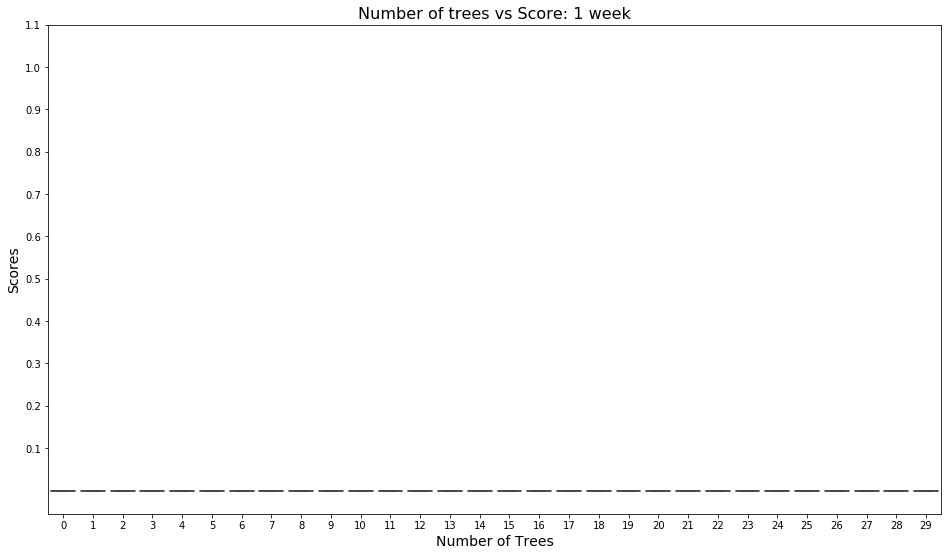

In [30]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
#sns.boxplot(data  = df_1wk.scores, names = df_1wk.tree_counts.values )
sns.boxplot(data  = df_1wk.scores)


plt.title(  "Number of trees vs Score: 1 week", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.1, 1.2, 0.1 ) )
sns.set_context('poster')


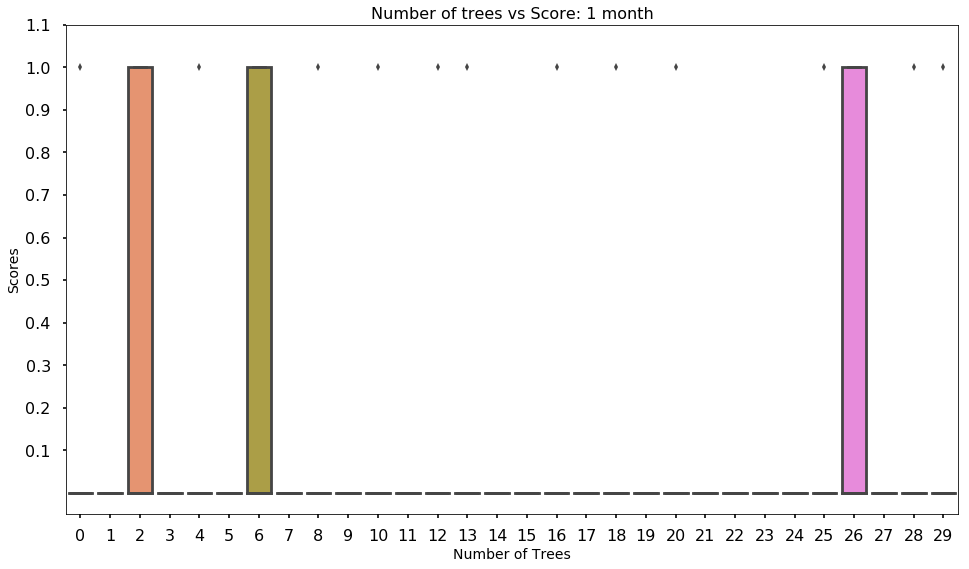

In [31]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
#sns.boxplot(data  = df_1m.scores, names = df_1m.tree_counts.values )
sns.boxplot(data  = df_1m.scores)

plt.title(  "Number of trees vs Score: 1 month", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.1, 1.2, 0.1 ) )
sns.set_context('poster')


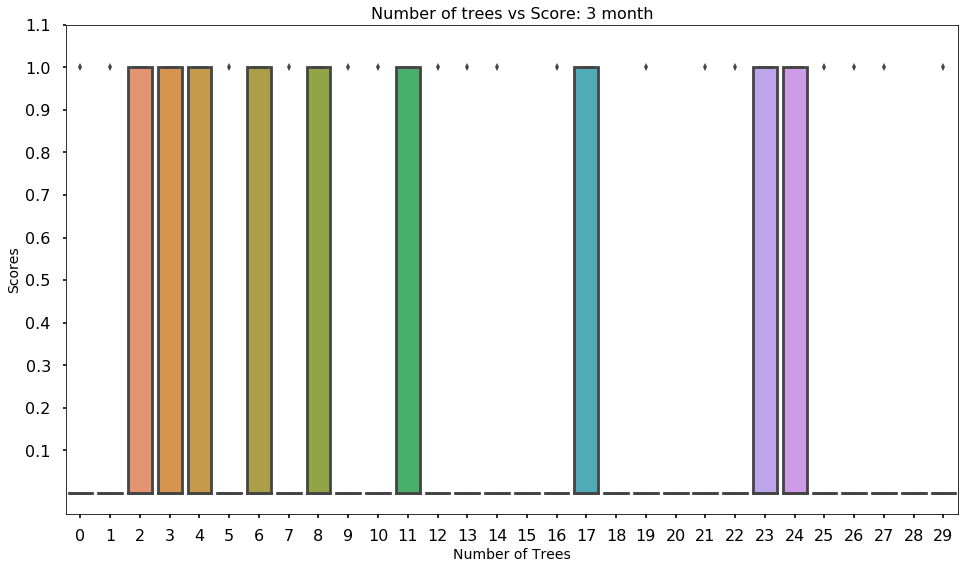

In [32]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(data  = df_3m.scores)

plt.title(  "Number of trees vs Score: 3 month", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.1, 1.2, 0.1 ) )
sns.set_context('poster')


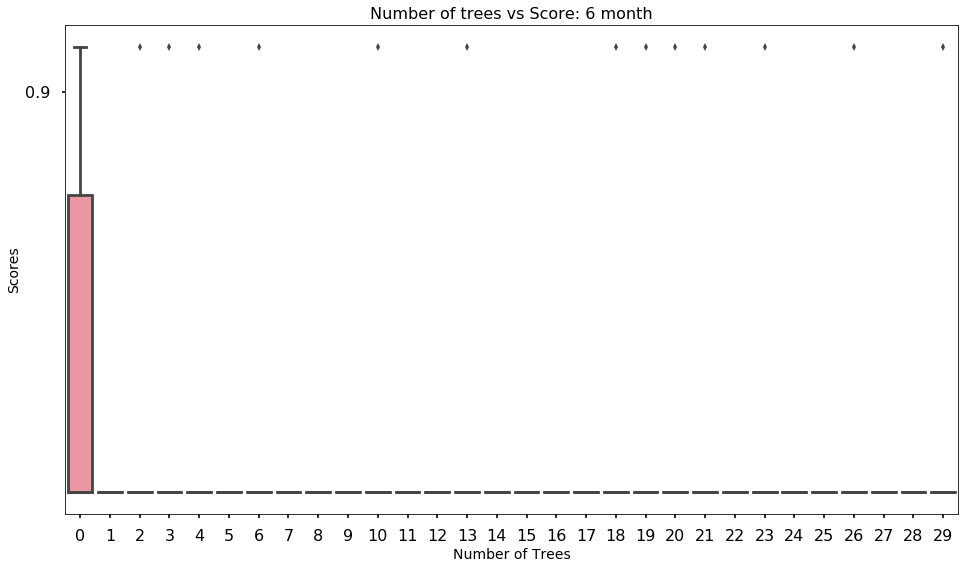

In [33]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot

sns.boxplot(data  = df_6m.scores)

plt.title(  "Number of trees vs Score: 6 month", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.9, 1.0, 0.1 ) )
sns.set_context('poster')


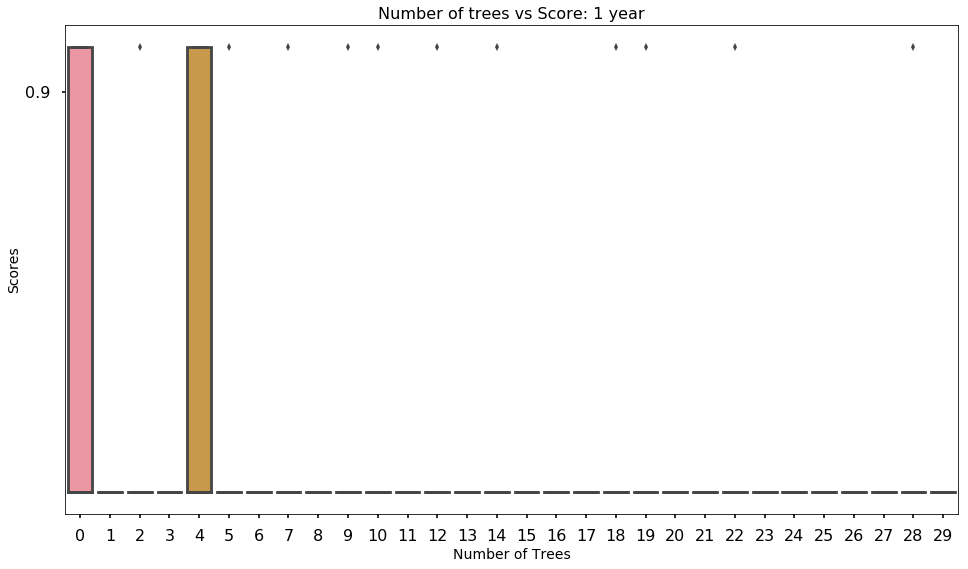

In [34]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(data  = df_1yr.scores)

plt.title(  "Number of trees vs Score: 1 year", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.9, 1.0, 0.1 ) )
sns.set_context('poster')


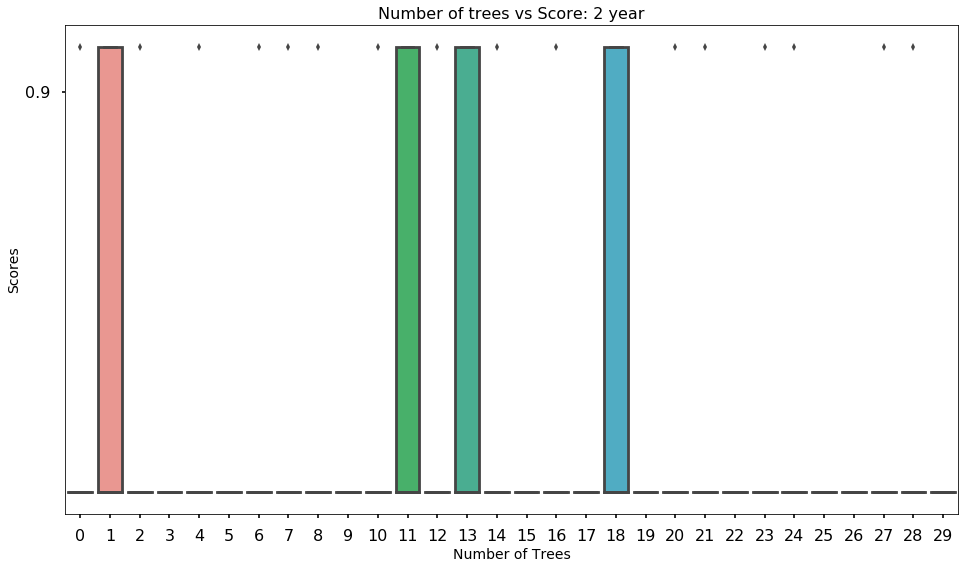

In [35]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(data  = df_2yr.scores)

plt.title(  "Number of trees vs Score: 2 year", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.9, 1.0, 0.1 ) )
sns.set_context('poster')


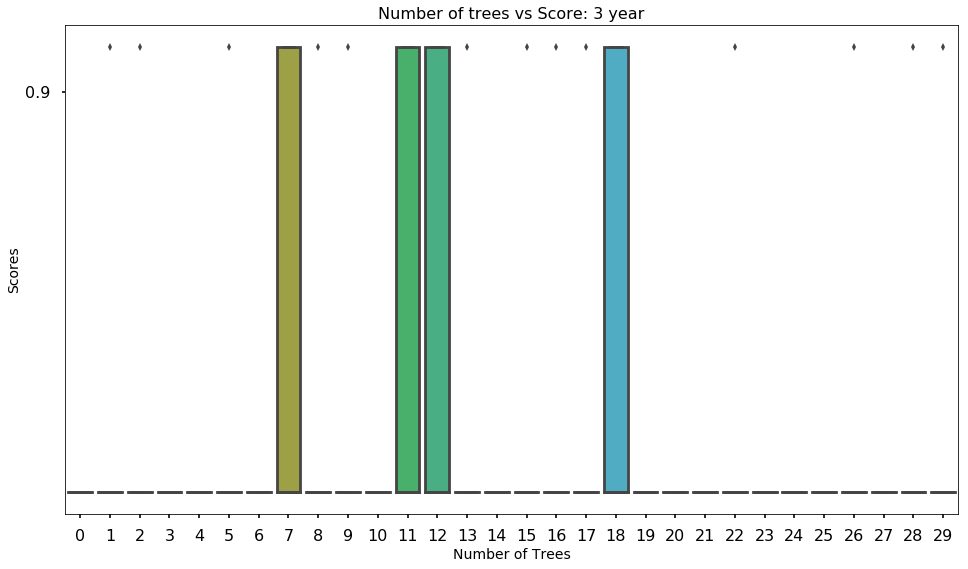

In [36]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(data  = df_3yr.scores)

plt.title(  "Number of trees vs Score: 3 year", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.9, 1.0, 0.1 ) )
sns.set_context('poster')


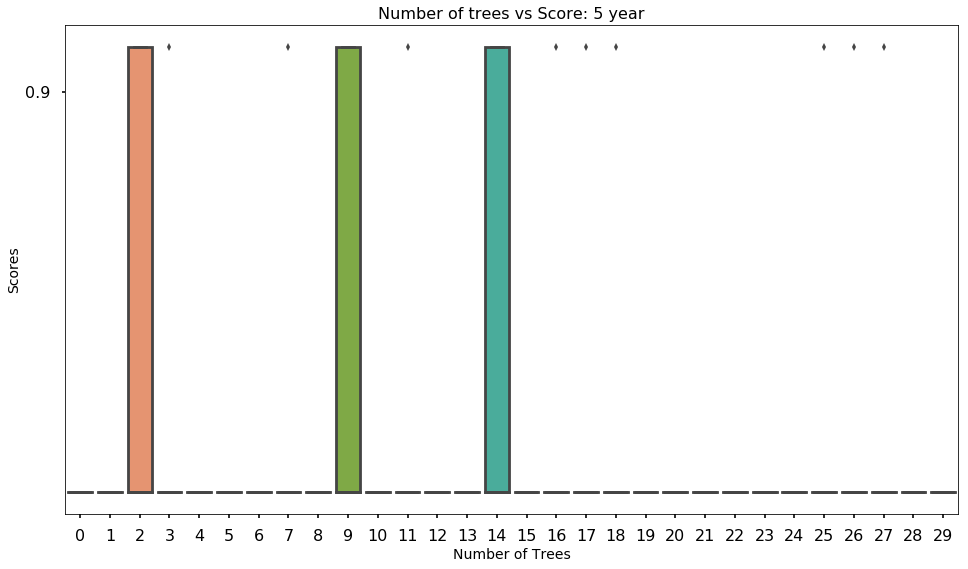

In [37]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(data  = df_5y.scores)

plt.title(  "Number of trees vs Score: 5 year", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.9, 1.0, 0.1 ) )
sns.set_context('poster')


In [38]:
##
# 1 week:
##
# Train random forest classifier with the optimal 27 estimators
## 

clfe_1wk = sklearn.ensemble.RandomForestClassifier( n_estimators = 27)
clfe_1wk = clfe_1wk.fit( Xv_1wk[:1000, :], Yp_1wk[:1000] )


##
# 1 month:
##
# Train random forest classifier with the optimal 27 estimators
## 

clfe_1m = sklearn.ensemble.RandomForestClassifier( n_estimators = 27)
clfe_1m = clfe_1m.fit( Xv_1m[:1000, :], Yp_1m[:1000] )

##
# 3 month:
##
# Train random forest classifier with the optimal 3 estimators
## 
clfe_3m = sklearn.ensemble.RandomForestClassifier( n_estimators = 3)
clfe_3m = clfe_3m.fit( Xv_3m[:1000, :], Yp_3m[:1000] )

##
# 6 month:
##
# Train random forest classifier with the optimal 2 estimators
## 
clfe_6m = sklearn.ensemble.RandomForestClassifier( n_estimators = 2)
clfe_6m = clfe_6m.fit( Xv_6m[:1000, :], Yp_6m[:1000] )

##
# 1 year:
##
# Train random forest classifier with the optimal 20 estimators
## 
clfe_1yr = sklearn.ensemble.RandomForestClassifier( n_estimators = 20)
clfe_1yr = clfe_1yr.fit( Xv_1yr[:1000, :], Yp_1yr[:1000] )

##
# 2 year:
##
# Train random forest classifier with the optimal 8 estimators
## 
clfe_2yr = sklearn.ensemble.RandomForestClassifier( n_estimators = 8)
clfe_2yr = clfe_2yr.fit( Xv_2yr[:1000, :], Yp_2yr[:1000] )

##
# 3 year:
##
# Train random forest classifier with the optimal 3 estimators
## 
clfe_3yr = sklearn.ensemble.RandomForestClassifier( n_estimators = 3)
clfe_3yr = clfe_3yr.fit( Xv_3yr[:1000, :], Yp_3yr[:1000] )

##
# 5 year:
##
# Train random forest classifier with the optimal 20 estimators
## 
clfe_5y = sklearn.ensemble.RandomForestClassifier( n_estimators = 20)
clfe_5y = clfe_5y.fit( Xv_5y[:1000, :], Yp_5y[:1000] )



# obtain the relative importance of the features 
imp_feature_1wk = clfe_1m.feature_importances_
imp_feature_1m = clfe_1m.feature_importances_
imp_feature_3m = clfe_3m.feature_importances_
imp_feature_6m = clfe_6m.feature_importances_
imp_feature_1yr = clfe_1yr.feature_importances_
imp_feature_2yr = clfe_2yr.feature_importances_
imp_feature_3yr = clfe_3yr.feature_importances_
imp_feature_5y = clfe_5y.feature_importances_

#get column names
columns = ['Scheme Risk',
            'CRISIL Rating',
            'Fund Family AUM',
            'Scheme AUM',
            'Latest NAV',
            'Fund Return',
            'Category Return'
          ]

# Diagnostics - Check relative importance of features
print imp_feature_1wk
print imp_feature_1m
print imp_feature_3m
print imp_feature_6m
print imp_feature_1yr
print imp_feature_2yr
print imp_feature_3yr
print imp_feature_5y


# Plot feature importances for each time frame
index = np.arange( len(columns) - 1 )
bar_width = 0.3
opacity = 0.5

[ 0.          0.3893957   0.          0.08397302  0.09661701  0.12911272
  0.18979045]
[ 0.          0.3893957   0.          0.08397302  0.09661701  0.12911272
  0.18979045]
[ 0.          0.33333333  0.          0.          0.33333333  0.33333333
  0.        ]
[ 0.          0.26595745  0.          0.          0.73404255  0.          0.        ]
[ 0.          0.41850306  0.          0.04489117  0.07128256  0.14230052
  0.17302268]
[ 0.          0.5         0.          0.18202815  0.05241362  0.11017628
  0.03038194]
[ 0.          0.3125      0.          0.02083333  0.33333333  0.26748971
  0.06584362]
[ 0.          0.45060844  0.          0.11351286  0.13611961  0.08431931
  0.11543977]


In [39]:
index = np.arange(6)
print(index)
print(imp_feature_1m)

[0 1 2 3 4 5]
[ 0.          0.3893957   0.          0.08397302  0.09661701  0.12911272
  0.18979045]


/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  after removing the cwd from sys.path.
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]


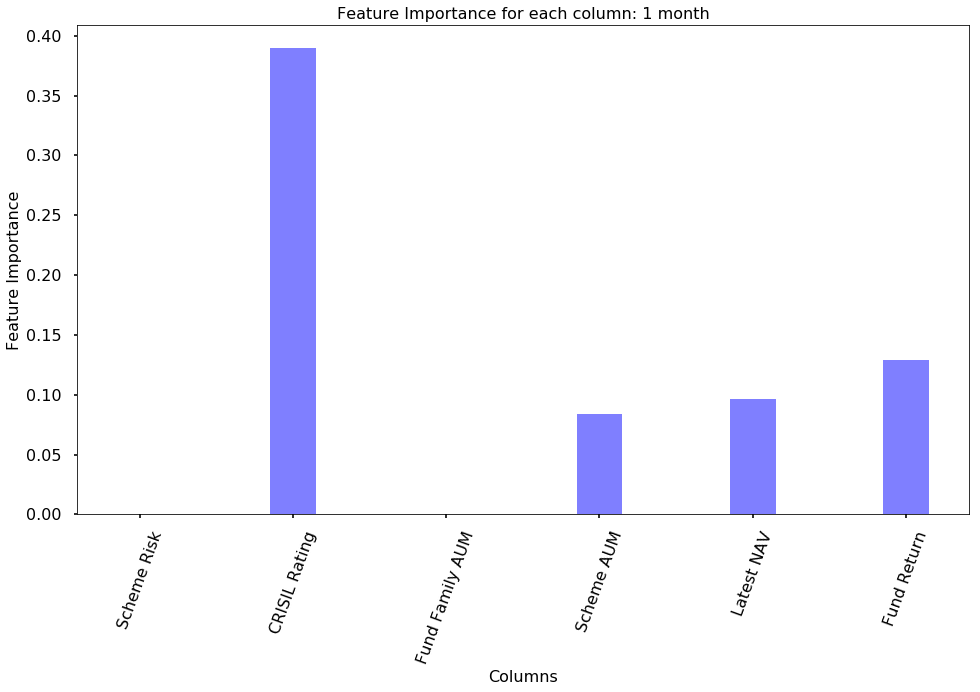

In [40]:
# 1 month
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( imp_feature_1m, [6, 7]),
        bar_width,
        alpha=opacity,
        color='b',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 1 month', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  after removing the cwd from sys.path.
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]


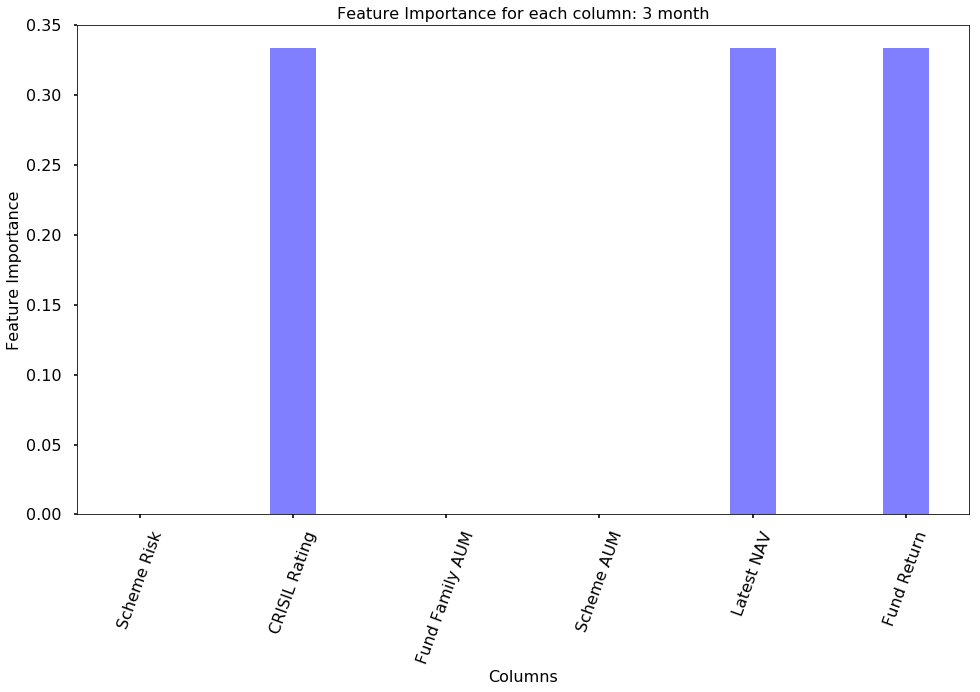

In [41]:
# 3 month
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( imp_feature_3m, [6,7]),
        bar_width,
        alpha=opacity,
        color='b',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 3 month', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  after removing the cwd from sys.path.
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]


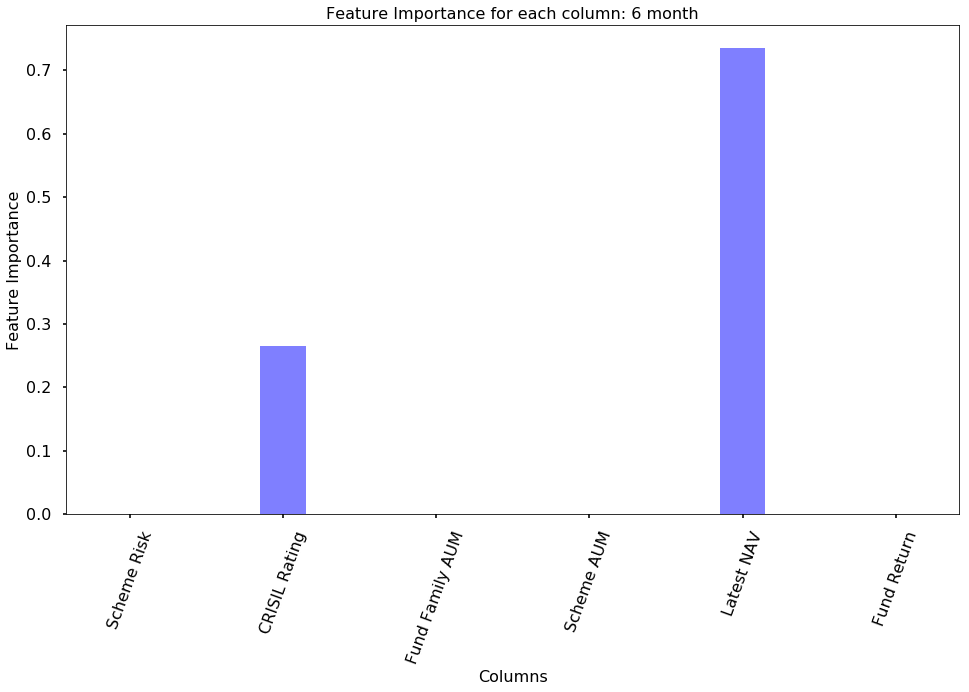

In [42]:
# 6 month
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( imp_feature_6m, [6,7]),
        bar_width,
        alpha=opacity,
        color='b',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 6 month', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  after removing the cwd from sys.path.
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]


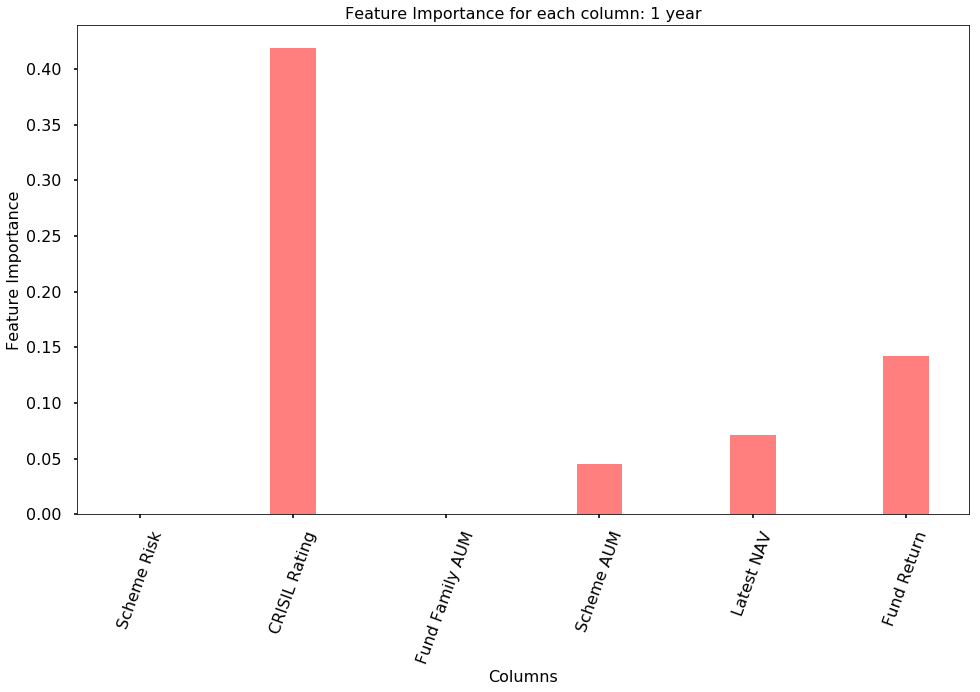

In [43]:
# 1 year
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( imp_feature_1yr, [6,7]),
        bar_width,
        alpha=opacity,
        color='r',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 1 year', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  after removing the cwd from sys.path.
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]


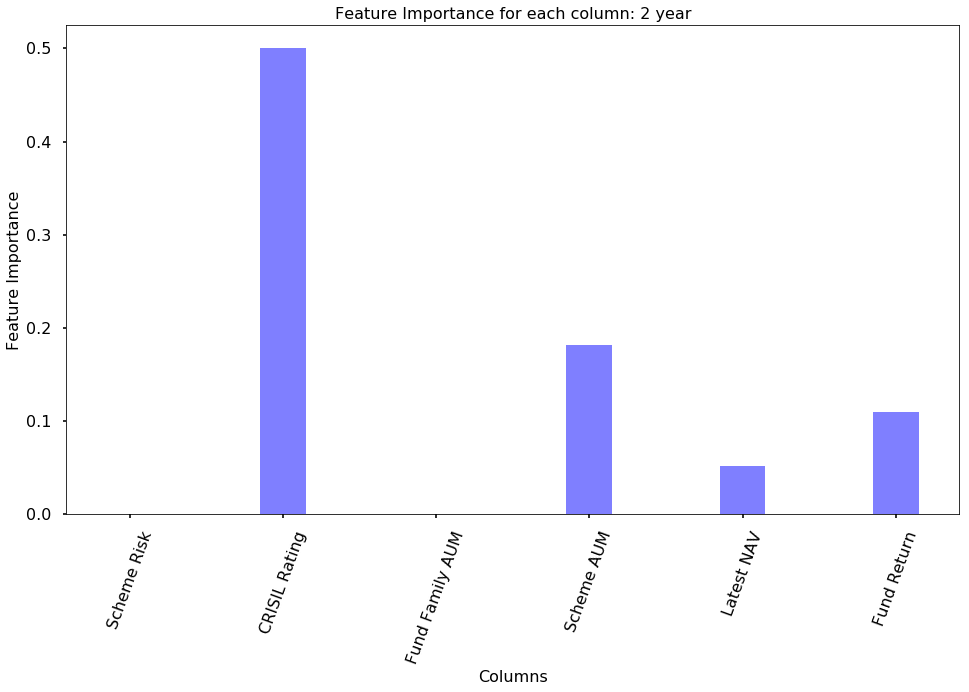

In [44]:
# 2 year
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( imp_feature_2yr, [6,7]),
        bar_width,
        alpha=opacity,
        color='b',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 2 year', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  after removing the cwd from sys.path.
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]


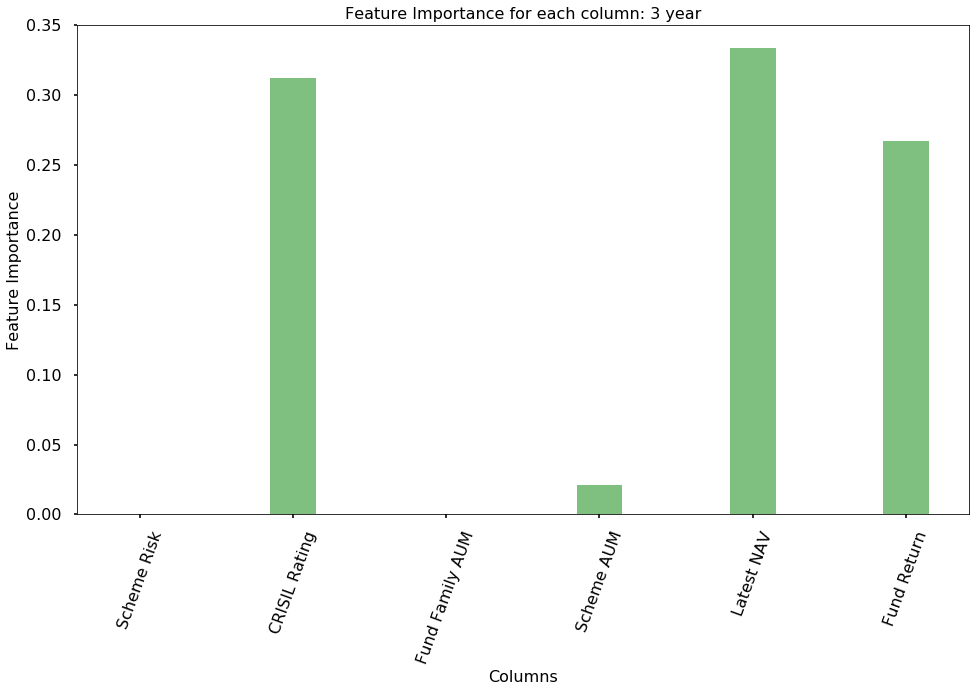

In [45]:
# 3 year
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( imp_feature_3yr, [6,7]),
        bar_width,
        alpha=opacity,
        color='g',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 3 year', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  after removing the cwd from sys.path.
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]


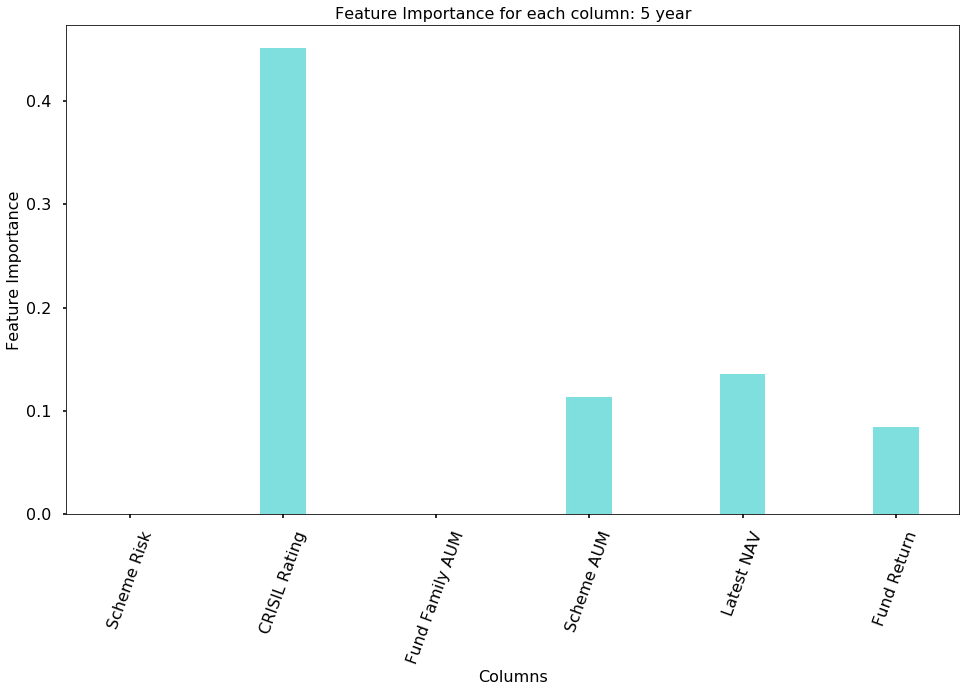

In [46]:
# 5 year
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( imp_feature_5y, [6,7]),
        bar_width,
        alpha=opacity,
        color='c',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 5 year', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

In [47]:
##
# Predict good and bad fund based on Random Forest Classification
##
Yp_1wk_predicted = clfe_1wk.predict( Xv_1wk )
Yp_1m_predicted = clfe_1m.predict( Xv_1m )
Yp_3m_predicted = clfe_3m.predict( Xv_3m )
Yp_6m_predicted = clfe_6m.predict( Xv_6m )
Yp_1yr_predicted = clfe_1yr.predict( Xv_1yr )
Yp_2yr_predicted = clfe_2yr.predict( Xv_2yr )
Yp_3yr_predicted = clfe_3yr.predict( Xv_3yr )
Yp_5y_predicted = clfe_5y.predict( Xv_5y )

In [48]:
print(Xv_1wk[1000:, :])
print(Yp_1wk[1000:])
print(clfe_1wk)

[]
[]
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=27, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [49]:
##
# Model Evaluation: Classification Score
##
clfe_1wk_score = clfe_1wk.score(Xv_1wk[1000:, :], Yp_1wk[1000:], sample_weight=None)
clfe_1m_score = clfe_1m.score(Xv_1m[1000:, :], Yp_1m[1000:], sample_weight=None)
clfe_3m_score = clfe_3m.score(Xv_3m[1000:, :], Yp_3m[1000:], sample_weight=None)
clfe_6m_score = clfe_6m.score(Xv_6m[1000:, :], Yp_6m[1000:], sample_weight=None)
clfe_1yr_score = clfe_1yr.score(Xv_1yr[1000:, :], Yp_1yr[1000:], sample_weight=None)
clfe_2yr_score = clfe_2yr.score(Xv_2yr[1000:, :], Yp_2yr[1000:], sample_weight=None)
clfe_3yr_score = clfe_3yr.score(Xv_3yr[1000:, :], Yp_3yr[1000:], sample_weight=None)
clfe_5y_score = clfe_5y.score(Xv_5y[1000:, :], Yp_5y[1000:], sample_weight=None)

ValueError: Found array with 0 sample(s) (shape=(0, 7)) while a minimum of 1 is required.

In [50]:
print('Timeframe: {0}\nScore: {1}\n'.format('1m', clfe_1m_score) ) 
print('Timeframe: {0}\nScore: {1}\n'.format('3m', clfe_3m_score) ) 
print('Timeframe: {0}\nScore: {1}\n'.format('6m', clfe_6m_score) ) 
print('Timeframe: {0}\nScore: {1}\n'.format('1y', clfe_1yr_score) ) 
print('Timeframe: {0}\nScore: {1}\n'.format('2y', clfe_2yr_score) ) 
print('Timeframe: {0}\nScore: {1}\n'.format('3y', clfe_3yr_score) ) 
print('Timeframe: {0}\nScore: {1}\n'.format('5y', clfe_5y_score) )

NameError: name 'clfe_1m_score' is not defined

In [51]:
## 
# List of good funds for each time frame
## 
recco_funds_1m = [ f_schemes[k] for (k, v) in enumerate( Yp_1m_predicted ) if v == 1.0 ]
recco_funds_3m = [ f_schemes[k] for (k, v) in enumerate( Yp_3m_predicted ) if v == 1.0 ]
recco_funds_6m = [ f_schemes[k] for (k, v) in enumerate( Yp_6m_predicted ) if v == 1.0 ]
recco_funds_1yr = [ f_schemes[k] for (k, v) in enumerate( Yp_1yr_predicted ) if v == 1.0 ]
recco_funds_2yr = [ f_schemes[k] for (k, v) in enumerate( Yp_2yr_predicted ) if v == 1.0 ]
recco_funds_3yr = [ f_schemes[k] for (k, v) in enumerate( Yp_3yr_predicted ) if v == 1.0 ]
recco_funds_5y = [ f_schemes[k] for (k, v) in enumerate( Yp_5y_predicted ) if v == 1.0 ]



In [52]:
recco_funds_1m_sort = [ [ fund['sch_name'], fund[ 'num_f_return_1m' ], fund[ 'num_f_return_3m' ], fund[ 'num_f_return_6m' ], fund[ 'num_f_return_1yr' ], fund[ 'num_f_return_2yr' ], fund[ 'num_f_return_3yr' ], fund[ 'num_f_return_5y' ], fund[ 'sch_url' ] ] for fund in recco_funds_1m]

recco_funds_3m_sort = [ [ fund['sch_name'], fund[ 'num_f_return_1m' ], fund[ 'num_f_return_3m' ], fund[ 'num_f_return_6m' ], fund[ 'num_f_return_1yr' ], fund[ 'num_f_return_2yr' ], fund[ 'num_f_return_3yr' ], fund[ 'num_f_return_5y' ], fund[ 'sch_url' ] ] for fund in recco_funds_3m]

recco_funds_6m_sort = [ [ fund['sch_name'], fund[ 'num_f_return_1m' ], fund[ 'num_f_return_3m' ], fund[ 'num_f_return_6m' ], fund[ 'num_f_return_1yr' ], fund[ 'num_f_return_2yr' ], fund[ 'num_f_return_3yr' ], fund[ 'num_f_return_5y' ], fund[ 'sch_url' ] ] for fund in recco_funds_6m]

recco_funds_1yr_sort = [ [ fund['sch_name'], fund[ 'num_f_return_1m' ], fund[ 'num_f_return_3m' ], fund[ 'num_f_return_6m' ], fund[ 'num_f_return_1yr' ], fund[ 'num_f_return_2yr' ], fund[ 'num_f_return_3yr' ], fund[ 'num_f_return_5y' ], fund[ 'sch_url' ] ] for fund in recco_funds_1yr]

recco_funds_2yr_sort = [ [ fund['sch_name'], fund[ 'num_f_return_1m' ], fund[ 'num_f_return_3m' ], fund[ 'num_f_return_6m' ], fund[ 'num_f_return_1yr' ], fund[ 'num_f_return_2yr' ], fund[ 'num_f_return_3yr' ], fund[ 'num_f_return_5y' ], fund[ 'sch_url' ] ] for fund in recco_funds_2yr]

recco_funds_3yr_sort = [ [ fund['sch_name'], fund[ 'num_f_return_1m' ], fund[ 'num_f_return_3m' ], fund[ 'num_f_return_6m' ], fund[ 'num_f_return_1yr' ], fund[ 'num_f_return_2yr' ], fund[ 'num_f_return_3yr' ], fund[ 'num_f_return_5y' ], fund[ 'sch_url' ] ] for fund in recco_funds_3yr]

recco_funds_5y_sort = [ [ fund['sch_name'], fund[ 'num_f_return_1m' ], fund[ 'num_f_return_3m' ], fund[ 'num_f_return_6m' ], fund[ 'num_f_return_1yr' ], fund[ 'num_f_return_2yr' ], fund[ 'num_f_return_3yr' ], fund[ 'num_f_return_5y' ], fund[ 'sch_url' ] ] for fund in recco_funds_5y]


In [53]:
    recco_funds_1m_sort.sort(key = lambda x: x[1], reverse=True)
    recco_funds_3m_sort.sort(key = lambda x: x[2], reverse=True)
    recco_funds_6m_sort.sort(key = lambda x: x[3], reverse=True)
    recco_funds_1yr_sort.sort(key = lambda x: x[4], reverse=True)
    recco_funds_2yr_sort.sort(key = lambda x: x[5], reverse=True)
    recco_funds_3yr_sort.sort(key = lambda x: x[6], reverse=True)
    recco_funds_5y_sort.sort(key = lambda x: x[7], reverse=True)

    print( '## Top 5 funds for a timeframe of 1 month:')
    print( recco_funds_1m_sort[:5] )

    print( '## Top 5 funds for a timeframe of 3 months:')
    print( recco_funds_3m_sort[:5] )

    print( '## Top 5 funds for a timeframe of 6 months:')
    print( recco_funds_6m_sort[:5] )

    print( '## Top 5 funds for a timeframe of 1 year:')
    print( recco_funds_1yr_sort[:5] )

    print( '## Top 5 funds for a timeframe of 2 years:')
    print( recco_funds_2yr_sort[:5] )

    print( '## Top 5 funds for a timeframe of 3 years:')
    print( recco_funds_3yr_sort[:5] )

    print( '## Top 5 funds for a timeframe of 5 years:')
    print( recco_funds_5y_sort[:5] )

## Top 5 funds for a timeframe of 1 month:
[[u'HDFC Dynamic Debt Fund - D (G)', 0.06, 0.36, 0.0, 3.34, 5.54, 17.34, 45.79, 'http://www.moneycontrol.com/mutual-funds/nav/hdfc-dynamic-debt-fund-direct-plan/MHD1199'], [u'HDFC Dynamic Debt Fund (G)', 0.02, 0.23, -0.34, 2.74, 4.26, 15.16, 40.62, 'http://www.moneycontrol.com/mutual-funds/nav/hdfc-dynamic-debt-fund/MZU008']]
## Top 5 funds for a timeframe of 3 months:
[[u'HDFC Dynamic Debt Fund - D (G)', 0.06, 0.36, 0.0, 3.34, 5.54, 17.34, 45.79, 'http://www.moneycontrol.com/mutual-funds/nav/hdfc-dynamic-debt-fund-direct-plan/MHD1199'], [u'HDFC Dynamic Debt Fund (G)', 0.02, 0.23, -0.34, 2.74, 4.26, 15.16, 40.62, 'http://www.moneycontrol.com/mutual-funds/nav/hdfc-dynamic-debt-fund/MZU008']]
## Top 5 funds for a timeframe of 6 months:
[[u'HDFC Dynamic Debt Fund - D (G)', 0.06, 0.36, 0.0, 3.34, 5.54, 17.34, 45.79, 'http://www.moneycontrol.com/mutual-funds/nav/hdfc-dynamic-debt-fund-direct-plan/MHD1199'], [u'HDFC Dynamic Debt Fund (G)', 0.02, 0.2

In [54]:
# Demonstrate class imbalance

# Print the number of good samples
print( sum(Yp_1m[1000:]), sum(Yp_3m), sum(Yp_6m), sum(Yp_1yr), sum(Yp_2yr), sum(Yp_3yr), sum(Yp_5y))

# Print the number of total samples
print( len(Yp_1m[1000:]), len(Yp_3m), len(Yp_6m), len(Yp_1yr), len(Yp_2yr), len(Yp_3yr), len(Yp_5y))


(0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0)
(0, 50, 50, 50, 50, 50, 50)
